In [3]:
# libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from utils import create_dataset_mri, cv

#CDE
from cde.density_estimator import MixtureDensityNetwork
from tensorflow.python.keras.activations import tanh

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# load the data
behavioral = pd.read_csv("data/Behavioral/AllData.csv")
# eeg_average = pd.read_csv("data/EEG/resting_eeg_average.csv")
# eeg_channels = pd.read_csv("data/EEG/resting_eeg_channels.csv")
# eeg_clusters = pd.read_csv("data/EEG/resting_eeg_clusters.csv")

# general info
shape = behavioral.shape  #2096, 7042
print(shape)

(2096, 7042)


In [4]:
list(filter(lambda x: "SWAN" in x, behavioral.columns))

['SWAN_01',
 'SWAN_02',
 'SWAN_03',
 'SWAN_04',
 'SWAN_05',
 'SWAN_06',
 'SWAN_07',
 'SWAN_08',
 'SWAN_09',
 'SWAN_10',
 'SWAN_11',
 'SWAN_12',
 'SWAN_13',
 'SWAN_14',
 'SWAN_15',
 'SWAN_16',
 'SWAN_17',
 'SWAN_18',
 'SWAN_IN_Avg',
 'SWAN_HY_Avg',
 'SWAN_Avg']

In [5]:
target = 'SWAN_HY_Avg'
#disease = None
disease = 'Attention-Deficit/Hyperactivity Disorder'
category = 'DX_01_Sub' #Irrelevant since we are dropping the columns after

In [6]:
# Create the dataset dropping the diagnosis columns since we are not interested in them
data = create_dataset_mri(select_disease = disease, select_category = category, SCORE = target)
try:
    data.drop(columns=['DX_01_Cat'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01_Sub'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01'], inplace=True)
except:
    pass


# Drop the rows with some NaNs

print(data.shape)
data.dropna(axis=0, inplace=True)
print(data.shape)
column_names = data.columns[2:]

(463, 371)
(450, 371)


In [7]:
data[target].unique()

array([ 1.888888,  0.666666,  1.444444,  1.222222,  0.777777,  0.555555,
        1.666666,  2.      ,  2.222222, -0.444444,  0.888888,  0.444444,
        0.333333,  2.333333,  0.111111,  0.      ,  2.777777,  1.      ,
       -0.888888,  1.333333, -0.222222,  2.555555, -0.555555,  1.555555,
       -0.111111, -1.222222, -0.666666,  1.777777,  1.111111,  0.222222,
       -2.      , -0.333333,  2.111111, -1.333333,  2.666666,  3.      ,
       -1.      , -2.333333, -1.555555, -1.777777, -2.222222, -2.666666,
       -1.111111, -2.444444, -1.444444, -3.      ])

In [8]:
# Define the labels and the features for regression
y = data[target]
X = data.drop([target, 'ID'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Store the dimensionality of the input
input_dim = X.shape[1]

# Naive regression with the whole dataset

In [9]:
# Baseline: predict always the average
pred = np.mean(y)
mse = sum((pred - y)**2)/len(y)
print('Prediction: {}'.format(pred))
print('MSE: {}'.format(mse))

Prediction: 0.7597527822222222
MSE: 0.9256829746520547


In [12]:
# Linear regression (qua c'è qualche errore, mse troppo alto)
lr = LinearRegression()
lr_cv_res = cv(lr, data=X_scaled, labels=y, n_splits=10)
print(lr_cv_res)
print('\nAverage MSE: {}'.format(np.mean(lr_cv_res)))

[13.726560390426256, 11.678536111101463, 11.40741113624376, 12.85375674955374, 11.716286563128588, 15.611747385700253, 10.012030029087073, 11.264819270522063, 9.632618068242783, 11.125105621389595]

Average MSE: 11.902887132539556


In [13]:
# SVM
svm = SVR(kernel='rbf', C=1, epsilon=0.1)
svm_cv_res = cv(svm, data=X_scaled, labels=y, n_splits=10)
print(svm_cv_res)
print('\nAverage MSE: {}'.format(np.mean(svm_cv_res)))

[0.8483457900096906, 0.7687666163904371, 0.668689510659259, 0.9255312289404063, 0.7811757224152662, 0.9049823396092317, 0.5725072199709732, 1.2024298917934781, 0.6560587212247352, 1.5134209496891367]

Average MSE: 0.8841907990702614


In [20]:
# Random Forest
rf = RandomForestRegressor(n_estimators=200, criterion='mse', n_jobs=4)
rf_cv_res = cv(rf, data=X, labels=y, n_splits=10)
print(rf_cv_res)
print('\nAverage MSE: {}'.format(np.mean(rf_cv_res)))

[0.9603309230879913, 0.7381232281546996, 0.6909680717355688, 0.8991162780639032, 0.7641234922496699, 1.0029958895540394, 0.5430251589022541, 1.2087339005808402, 0.6761842523224478, 1.5458710015622639]

Average MSE: 0.9029472196213678


In [16]:
# CDE
def cv_for_cde(data, labels, n_splits = 5):
    '''
    model: must be a sklearn object with .fit and .predict methods
    data: the X matrix containing the features, can be a pd.DataFrame or a np object (array or matrix)
    labels: y, can be a pd.DataFrame or a np array
    n_splits: number of desired folds
    => returns array of mean suqared error calculated on each fold
    '''
    kf = KFold(n_splits=n_splits)
    data = np.array(data)
    labels = np.array(labels)
    mses = []
    i = 1
    for train, test in kf.split(data):
        model = MixtureDensityNetwork(name="MDN" + str(i),
                              ndim_x=input_dim,
                              ndim_y=1,
                              n_centers=10,
                              hidden_sizes=(16, 16),
                              hidden_nonlinearity=tanh,
                              n_training_epochs=1000,
                              x_noise_std=1,
                              y_noise_std=1
                             )
        
        print("Split: {}".format(i), end="\r")
        X_train, X_test, y_train, y_test = data[train], data[test], labels[train], labels[test]
        model.fit(X=X_train, Y=y_train, verbose=True)
        pred = model.mean_(X_test)
        pred = pred.reshape((-1,1)).flatten()
        mse = sum((pred - y_test)**2)/len(test)
        mses.append(mse)
        i = i+1
    return mses

res = cv_for_cde(data=X, labels=y, n_splits=5)
np.mean(res)

# Feature Selection

In [24]:
from sklearn.ensemble import ExtraTreesRegressor

Most relevant feature: lh_G_oc.temp_med.Lingual_thickness


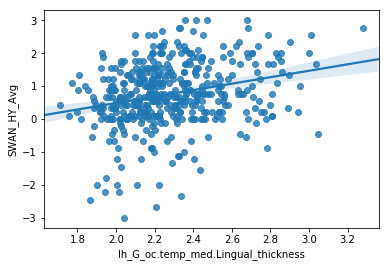

In [25]:
# Tree-based feature selection
tree = ExtraTreesRegressor(n_estimators=100, n_jobs=4)
tree = tree.fit(X=X, y=y)
weights = tree.feature_importances_

# Display correlation between most relevant feature and signal
most_relevant_feature = column_names[weights == max(weights)][0]
dataset = data[[target, most_relevant_feature]]
print('Most relevant feature: {}'.format(most_relevant_feature))
sns.regplot(x = most_relevant_feature, y = target ,data = dataset)

In [26]:
# Take the k most relevant features
k = 20
kth_weight = np.sort(weights)[::-1][k]
k_most_relevant = column_names[weights>= kth_weight]
print(k_most_relevant)

Index(['lh_G.S_frontomargin_thickness', 'lh_G.S_occipital_inf_thickness',
       'lh_G_cuneus_thickness', 'lh_G_oc.temp_med.Lingual_thickness',
       'lh_G_precentral_thickness', 'lh_G_temp_sup.Plan_polar_thickness',
       'lh_S_calcarine_thickness', 'rh_G_front_inf.Opercular_thickness',
       'rh_G_oc.temp_med.Lingual_thickness', 'rh_G_rectus_thickness',
       'rh_S_calcarine_thickness', 'rh_S_circular_insula_ant_thickness',
       'rh_S_suborbital_thickness', 'lh_G_cingul.Post.dorsal_volume',
       'lh_S_orbital_med.olfact_volume', 'rh_G_cingul.Post.dorsal_volume',
       'rh_G_front_inf.Triangul_volume', 'rh_S_collat_transv_post_volume',
       'rh_S_interm_prim.Jensen_volume', 'rh_S_temporal_transverse_volume',
       'rh_entorhinal_volume'],
      dtype='object')


# Regression with selected features

Nota: in teoria questo sarebbe cheating, visto che in cross validation la feature selection andrebbe fatta solo sul training set mentre qua la stiamo facendo su tutti i dati, però lo stiamo facendo giusto per orientarci con le features e per capire se le cose migliorano in questo verso.

In [27]:
X_selected = data[list(k_most_relevant)]
X_selected_scaled = scaler.fit_transform(X_selected)
X_selected.shape

(450, 21)

In [28]:
# Linear regression
lr = LinearRegression()
lr_cv_res = cv(lr, data=X_selected, labels=y, n_splits=10)
print(lr_cv_res)
print('\nAverage MSE: {}'.format(np.mean(lr_cv_res)))

[0.7568071475259921, 0.8595089041674716, 0.7699736431507157, 0.8360510111441076, 0.7428008272862954, 0.9785967347381208, 0.5747998935980297, 1.288538225260472, 0.6712359020618728, 1.3596309348518945]

Average MSE: 0.8837943223784972


In [29]:
# SVM
svm = SVR(kernel='rbf', C=1, epsilon=0.1)
svm_cv_res = cv(svm, data=X_selected_scaled, labels=y, n_splits=10)
print(svm_cv_res)
print('\nAverage MSE: {}'.format(np.mean(svm_cv_res)))

[0.7731502884872627, 0.8562380000886708, 0.6689584629758495, 0.8283563159436553, 0.7534722468304352, 0.9306524548512616, 0.5519923964752101, 1.3153520760552562, 0.5892271027189195, 1.4606603944185048]

Average MSE: 0.8728059738845027


In [30]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, criterion='mse', n_jobs=4)
rf_cv_res = cv(rf, data=X_selected, labels=y, n_splits=10)
print(rf_cv_res)
print('\nAverage MSE: {}'.format(np.mean(rf_cv_res)))

[0.8556876706213861, 0.7268044343922216, 0.7103945659255292, 0.9977770187099921, 0.7003671876507555, 0.9166054138733887, 0.5792472544375927, 1.2744871003165748, 0.5775947542658713, 1.4556195531378266]

Average MSE: 0.8794584953331139
